# CR Hamiltonian tomography using OpenPulse

In this Jupyter notebook we show how to investigate Hamiltonian of cross resonance (CR) pulse. We do this by measuring a statevector of target qubit at each pulse duration of CR Rabi experiment [1]. This notebook does the following steps

1) Create pulse schedules for CR Rabi experiment.

2) Create tomography schedules for each CR Rabi schedule.

3) Create fitter to reconstruct CR Hamiltonian.  

---
Check the following reference for the detailed description.  
  
[1] Sheldon, S., Magesan, E., Chow, J. M. & Gambetta, J. M. Procedure for systematically tuning up cross-talk in the cross-resonance gate. Phys. Rev. A 93, 060302 (2016).  
[2] Magesan, E. & Gambetta, J. M. Effective Hamiltonian models of the cross-resonance gate. (2018).

In [11]:
import numpy as np
from qiskit import IBMQ, assemble
from qiskit.ignis.characterization.hamiltonian import cr_tomography_schedules, cr1_rabi_schedules, cr2_rabi_schedules, CRFitter

## 1. Load backend supporting OpenPulse
Backend should support OpenPulse and level2 measurement. If level2 measurement is not supported, use discriminator module to convert level1 result into level2.

In [2]:
IBMQ.load_account()
ibmq_provider = IBMQ.get_provider(hub='hub', group='group', project='project')
backend = ibmq_provider.get_backend('backend')

## 2. Creating CR Rabi schedule
In this module, two types of CR schedule are provided. If you want to investigate CR Hamiltonian of customized pulse sequence, you can manually create `List[Schedules]` with several pulse duration for measuring Rabi oscillation. It should be noted that there are several approximations on the following analyis [2] and customized schedule should not violate these approximations. 
- `cr1_rabi_schedules`: create schedules for one pulse CR
- `cr2_rabi_schedules`: create schedules for two pulse echoed CR

In this notebook, two pulse echoed CR is used to eliminate strong IX interaction, and cancellation pulse is just omitted.

In [3]:
cr_samples = np.linspace(50, 300, 20, dtype=int) * 2

cr_times, rabi_scheds = cr2_rabi_schedules(c_qubit=0, t_qubit=1,
                                           backend=backend, cr_samples=cr_samples,
                                           cr_amp=0.2, sigma=5, risefall=15)

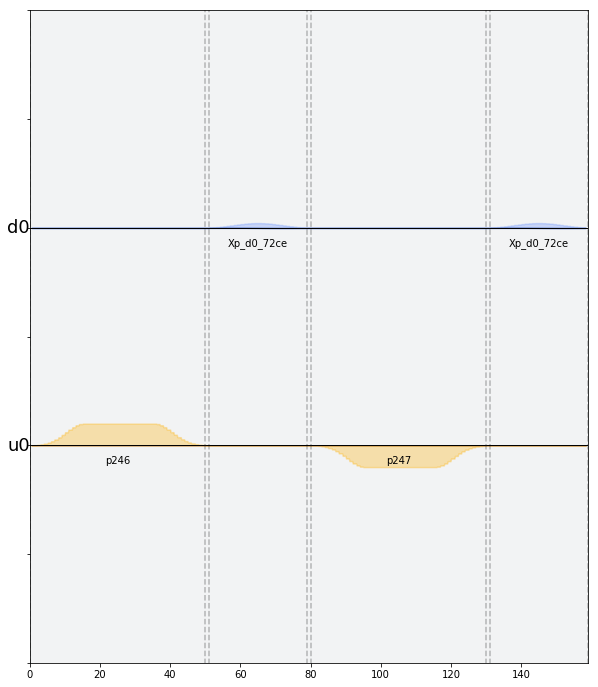

In [4]:
rabi_scheds[0].draw(label=True)

## 3. Creating CR tomography schedule
Add initial state preparation and measurement schedules. Each schedule name follows the naming rule of `[index],[measurement basis],[control qubit state]`.

In [5]:
tomo_scheds = cr_tomography_schedules(c_qubit=0, t_qubit=1, backend=backend, rabi_schedules=rabi_scheds)

Let's visualize some schedules to understand what is created.

In [6]:
# for visualization
plot_channels = [tomo_scheds[1].channels[0], tomo_scheds[1].channels[1], tomo_scheds[1].channels[2],  tomo_scheds[1].channels[44],  tomo_scheds[1].channels[45]]

CR Rabi index 0, initial state |00>, measured in Pauli-X basis

0,x,0


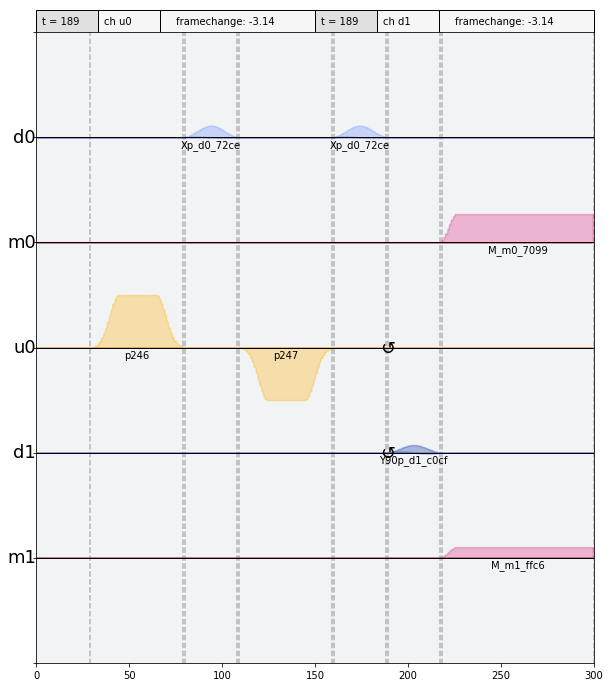

In [7]:
print(tomo_scheds[0].name)
tomo_scheds[0].draw(label=True, channels_to_plot=plot_channels, plot_range=(0, 300), scaling=5)

CR Rabi index 0, initial state |01>, measured in Pauli-X basis

0,x,1


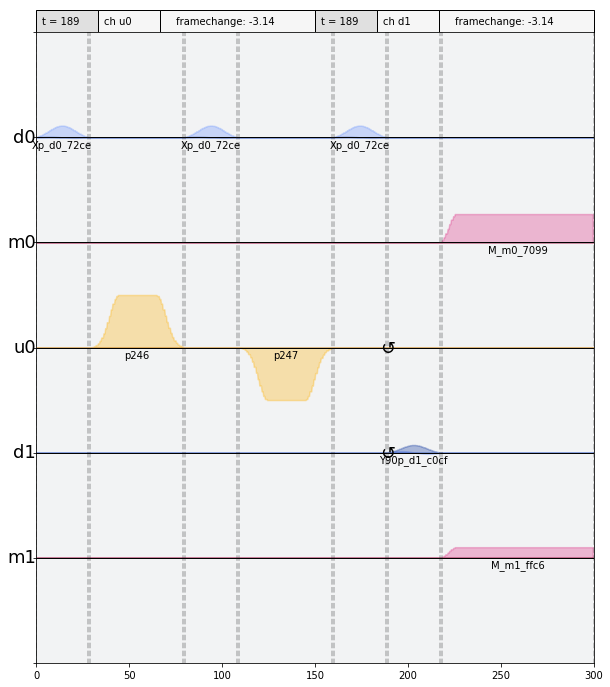

In [8]:
print(tomo_scheds[1].name)
tomo_scheds[1].draw(label=True, channels_to_plot=plot_channels, plot_range=(0, 300), scaling=5)

CR Rabi index 0, initial state |00>, measured in Pauli-Y basis

0,y,0


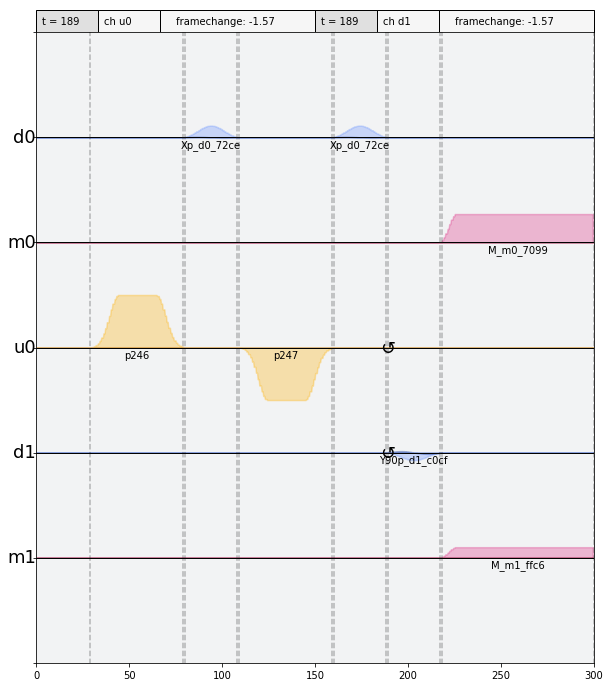

In [9]:
print(tomo_scheds[2].name)
tomo_scheds[2].draw(label=True, channels_to_plot=plot_channels, plot_range=(0, 300), scaling=5)

CR Rabi index 0, initial state |00>, measured in Pauli-Z basis

0,z,0


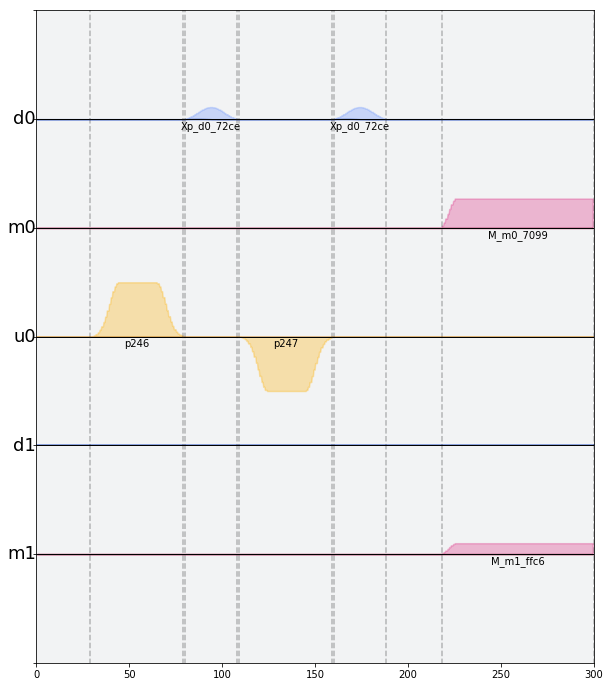

In [10]:
print(tomo_scheds[4].name)
tomo_scheds[4].draw(label=True, channels_to_plot=plot_channels, plot_range=(0, 300), scaling=5)

In [11]:
qobj = assemble(tomo_scheds, backend, meas_level=2, shots=1024)

In [12]:
job = backend.run(qobj)

In [17]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [14]:
job.job_id()

'5db18bf524de69001171fd0b'

## 4. Analyze tomography result

In [5]:
tomo_results = job.result(timeout=3600)

In [6]:
fitter = CRFitter(backend_result=tomo_results, t_qubit=1, cr_times=cr_times)

In [7]:
fitter.fit(fit0=[-4e6, 4e6, 0], fit1=[-4e6, 4e6, 0], method='Nelder-Mead')

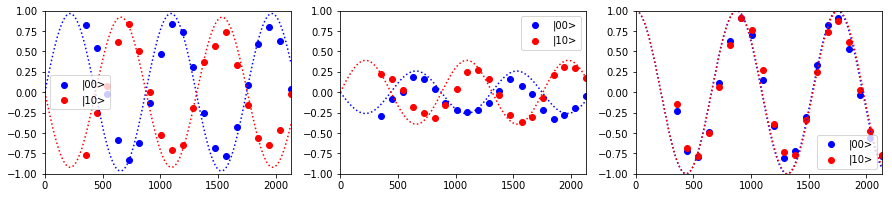

In [8]:
fitter.plot_rabi_oscillation()

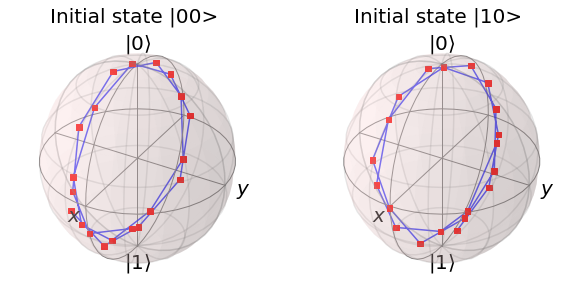

In [9]:
fitter.plot_bloch_vec()

In [10]:
fitter.hamiltonian()

{'IX': -465052.4609555376,
 'IY': 176093.02591453772,
 'IZ': 0.0065914466876722975,
 'ZX': 2335880.1968798153,
 'ZY': 6762779.9546796335,
 'ZZ': -0.009025406095330974}

## 5. Comparing with aother CR schedule
In previous experiment, we used CR2-type experiment to alleviate strong IX interaction. In this section, we try CR1-type experiment, which may induce strong IX interaction.

In [12]:
cr_times, rabi_scheds = cr1_rabi_schedules(c_qubit=0, t_qubit=1,
                                           backend=backend, cr_samples=cr_samples,
                                           cr_amp=0.2, sigma=5, risefall=15)

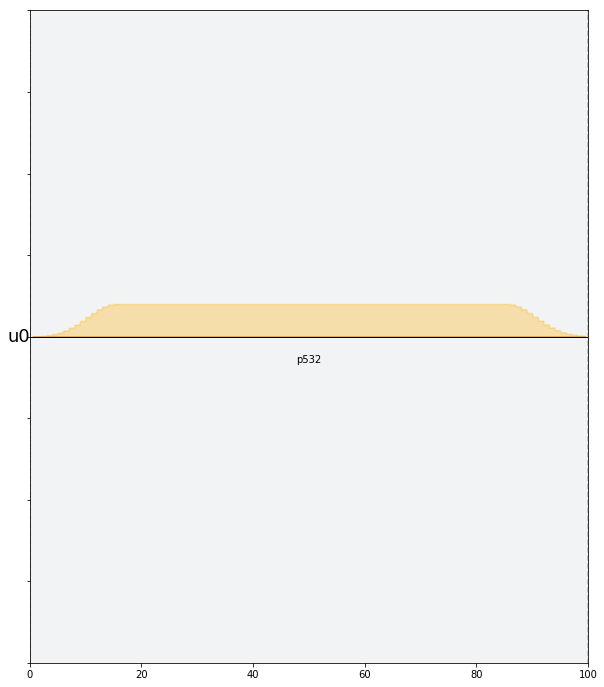

In [13]:
rabi_scheds[0].draw(label=True)

In [14]:
tomo_scheds = cr_tomography_schedules(c_qubit=0, t_qubit=1, backend=backend, rabi_schedules=rabi_scheds)

In [15]:
qobj = assemble(tomo_scheds, backend, meas_level=2, shots=1024)

In [16]:
job = backend.run(qobj)

In [19]:
job.status()

<JobStatus.RUNNING: 'job is actively running'>

In [18]:
job.job_id()

'5db1ad1db983a00011559b6d'

In [20]:
tomo_results = job.result(timeout=3600)

In [21]:
fitter = CRFitter(backend_result=tomo_results, t_qubit=1, cr_times=cr_times)

As you can see, oscillation period of |00> and |01> initial states are remarkably different, and this may make it difficult to fit oscillation by `CRFitter`. Echoed CR can alleviate interactions which commutes with ZX, which yields suitable result for post analysis.

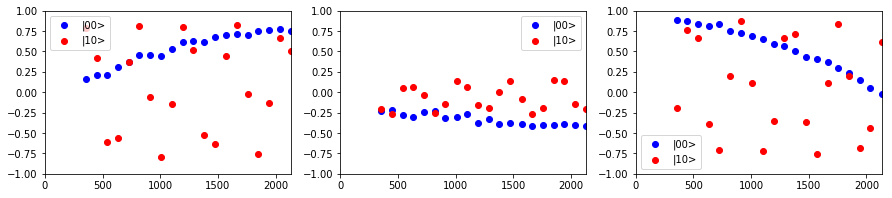

In [22]:
fitter.plot_rabi_oscillation()